In [ ]:
import os
import warnings
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans



warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)

2025-06-23 06:52:39.398620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750661559.441719     642 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750661559.459044     642 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def seed_everything(seed: int,
                   tensorflow_init: bool =True,
                   pytorch_init: bool =True,
                   ) -> None:
    """
    Set the seed for various random number generators to ensure reproducibility.

    This function seeds Python's built-in random module, NumPy, TensorFlow, PyTorch,
    and optionally configures PySpark to use the given seed.

    Args:
        seed (int): The seed value to use for all random number generators.
        tensorflow_init (bool, optional): Whether to seed TensorFlow's RNG. Defaults to True.
        pytorch_init (bool, optional): Whether to seed PyTorch's RNG. Defaults to True.
        pyspark_init (bool, optional): Whether to seed PySpark's RNG. Defaults to True.

    Notes:
        - For PyTorch, this function sets torch.backends.cudnn.deterministic=True and
          torch.backends.cudnn.benchmark=False to improve reproducibility at the cost of performance.
        - PySpark does not have a direct global RNG seed setter; this function sets the seed on
          the SparkContext's random seed configuration and on the Python random module used in driver.
          However, worker tasks should explicitly use seeded RNGs for full reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if tensorflow_init is True:
        tf.random.set_seed(seed)

    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(0x2A, False, False)


Accelerator: cpu | Torch 2.6.0+cu124


In [6]:
csv_path = '/kaggle/input/avitoautotrain/avito_train_utf8.csv'

In [7]:
df = pd.read_csv(csv_path, encoding='utf-8')

print(f"\nMain dataset shape: {df.shape}\n")
print(f"\nMain dataset columns: {df.columns.tolist()}\n")

print("\nData types:\n")
print(df.dtypes)

print("\nFirst 5 rows of main dataset:\n")
df.head()


Main dataset shape: (45628, 25)


Main dataset columns: ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id', 'price', 'url']


Data types:

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate               float64
name                     object
numberOfDoors           float64
productionDate          float64
vehicleConfiguration     object
vehicleTransmission      object
engineDisplacement       object
enginePower              object
description              object
mileage                 float64
Комплектация             object
Привод                   object
Руль                     object
Состояние                object
Владельцы                 int64

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,price,url
0,внедорожник 5.0 дв.,KIA,коричневый,бензин,2009.0,2.4 4WD AT (175 л.с.),5.0,2009.0,внедорожник автомат 2.4,автоматическая,2.4 LTR,175 N12,"Авто в идеальном состоянии, мультимедиа, навиг...",141000.0,Luxe,полный,левый,не битый,2,Оригинал,Растаможен,6 лет 3 месяца,0,950000.0,https://www.avito.ru/moskva/avtomobili/kia_sor...
1,седан 4.0 дв.,Mercedes-Benz,чёрный,бензин,2006.0,E 350 3.5 4Matic AT (272 л.с.),4.0,2006.0,седан автомат 3.5,автоматическая,3.5 LTR,350 N12,"ПТС оригинал, в ДТП не участвовала. 。Подушка б...",151754.0,AVANTGARDE,полный,левый,не битый,3,Оригинал,Растаможен,5 лет 2 месяца,1,529000.0,https://www.avito.ru/moskva/avtomobili/mercede...
2,седан 4.0 дв.,Volkswagen,белый,бензин,2015.0,1.6 MPI MT (110 л.с.),4.0,2015.0,седан механика 1.6,механическая,1.6 LTR,110 N12,Данная цена достигается путем сложения всех ск...,0.0,Connect,передний,левый,NaN,0,Оригинал,Растаможен,NaN,2,724400.0,https://www.avito.ru/moskva/avtomobili/volkswa...
3,седан 4.0 дв.,Volkswagen,белый,бензин,2008.0,1.8 TSI DSG (152 л.с.),4.0,2008.0,седан робот 1.8,роботизированная,1.8 LTR,152 N12,В ДТП не участвовала. ☛ Все заявленные автомоб...,87152.0,Базовая,передний,левый,не битый,4,Оригинал,Растаможен,3 года 2 месяца,3,549000.0,https://www.avito.ru/moskva/avtomobili/volkswa...
4,седан 4.0 дв.,Subaru,синий,бензин,2005.0,2.5 4WD MT (230 л.с.),4.0,2005.0,седан механика 2.5,механическая,2.5 LTR,230 N12,Двигатель сказал салам алейкумЦена договорнаяВ...,225000.0,Базовая,полный,левый,не битый,4,Оригинал,Растаможен,4 года 2 месяца,4,400000.0,https://www.avito.ru/moskva/avtomobili/subaru_...


In [8]:
rename_dict = {
    "Комплектация": "equipment",
    "Привод": "drive",
    "Руль": "steering_wheel",
    "Состояние": "condition",
    "Владельцы": "owners",
    "ПТС": "pts",
    "Таможня": "customs_cleared",
    "Владение": "ownership_duration"
}

def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [9]:
df = df.rename(columns=rename_dict)

df.columns = [camel_to_snake(col) for col in df.columns]

In [10]:
df.drop(columns=['url', 'id'], axis=1, inplace=True)

print(df.shape)

(45628, 23)


In [ ]:
df.drop(columns=
        ['description', 
        ], 
        axis=1, 
        inplace=True,
       )

In [23]:
def clean_body_type(body_type):
    cleaned = re.sub(r'\d+\.\d+\s*дв\.?', '', body_type).strip()
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned if cleaned else body_type

In [24]:
df['body_type'] = df['body_type'].apply(clean_body_type)

In [25]:
def get_ownership_months(duration_str):
    if pd.isna(duration_str):
        return np.nan
    
    years_match = re.search(r'(\d+)\s*(год|лет)', duration_str)
    months_match = re.search(r'(\d+)\s*(месяц)', duration_str)
    
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    
    total_months = years * 12 + months
    
    return total_months

In [26]:
df['ownership_months'] = df['ownership_duration'].apply(get_ownership_months)

df['condition'].fillna('битый', inplace=True)

df['engine_power_hp'] = df['engine_power'].str.extract(r'(\d+)').astype(float)
df['engine_displacement_ltr'] = df['engine_displacement'].str.extract(r'(\d+\.?\d*)').astype(float)

df['body_type_extracted'] = df['vehicle_configuration'].str.split().str[0]


In [27]:
df['body_type_extracted'] = df['vehicle_configuration'].str.split().str[0]
df['body_type_extracted'].fillna(df['body_type'], inplace=True)

power_from_engine_col = df['engine_power'].str.extract(r'(\d+)')
power_from_name_col = df['name'].str.extract(r'\((\d+)\s+л\.с\.\)')

df['engine_power_hp'] = power_from_engine_col.combine_first(power_from_name_col)
df['engine_power_hp'] = df['engine_power_hp'].astype('Int64')

disp_from_config = df['vehicle_configuration'].str.extract(r'(\d+\.\d+)')
disp_from_name = df['name'].str.extract(r'(\d+\.\d+)')

df['engine_displacement_ltr'] = disp_from_config.combine_first(disp_from_name)
df['engine_displacement_ltr'] = df['engine_displacement_ltr'].astype(float)

df.loc[df['fuel_type'] == 'электро', 'engine_displacement_ltr'] = 0
df.loc[df['name'].str.contains('30d', na=False), 'engine_displacement_ltr'] = 3.0

In [28]:
df.drop(columns=['ownership_duration', 'engine_power', 'vehicle_configuration', 'engine_displacement'], 
        axis=1, 
        inplace=True
       )

In [29]:
extracted = df['name'].str.extract(r'\((\d+)\s*л\.с\.\)', expand=False)

mask = extracted.notna()  
df.loc[mask, 'engine_power_hp'] = extracted[mask].astype(float)

In [30]:
df.drop(columns=['ownership_months'], axis=1, inplace=True)

In [31]:
# Tesla 100D (2016) - 416 л.с.
df.loc[1886, 'engine_power_hp'] = 416.0

# Tesla 85 (2012) - 362 л.с.
df.loc[9165, 'engine_power_hp'] = 362.0

# Tesla P85+ (2012) - 416 л.с.
df.loc[44169, 'engine_power_hp'] = 416.0

# Nissan Leaf (2010) - 109 л.с.
nissan_leaf_indices = [
    4697, 5773, 6326, 10806, 11895, 12806, 13435, 13438, 
    13823, 14412, 14604, 15030, 17561, 20438, 23579, 25594, 
    26335, 26731, 27979, 28800, 29905, 29975, 30621, 32607, 
    33007, 38556, 39110, 41269, 41294, 42958, 44984
]

df.loc[nissan_leaf_indices, 'engine_power_hp'] = 109.0

In [32]:
df['equipment'].fillna('Базовая', inplace=True)

In [33]:
df.loc[df['production_date'] > 2025, 'production_date'] -= 400

---

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

DBSCAN нашел 7448 шумовых точек (выбросов).
Запуск t-SNE для визуализации... (может занять время)


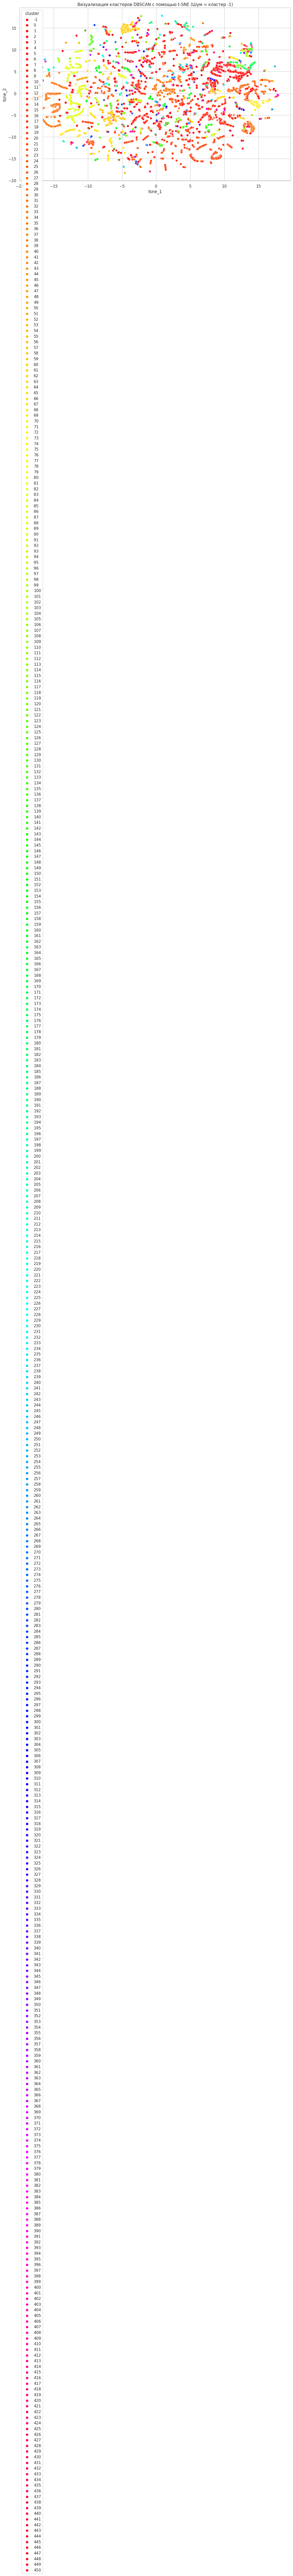


Удалено 7448 строк (16.39% данных).
Итоговое количество строк: 37990


In [ ]:
def clean_and_visualize_dbscan(df, columns_to_use, eps=0.5, min_samples=5):
    """
    Находит выбросы с помощью DBSCAN, визуализирует их через t-SNE и возвращает очищенный DataFrame.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    # 1. Подготовка данных
    data_subset = df_out[columns_to_use]
    
    # One-Hot Encoding для категориальных признаков
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    
    # Масштабирование
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")
    
    # 2. Кластеризация DBSCAN
    # eps и min_samples - ключевые параметры, их нужно подбирать под ваши данные!
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    cluster_labels = dbscan.fit_predict(data_scaled)
    df_out['cluster'] = cluster_labels
    
    noise_points_count = (df_out['cluster'] == -1).sum()
    print(f"\nDBSCAN нашел {noise_points_count} шумовых точек (выбросов).")
    
    # 3. Визуализация t-SNE
    print("Запуск t-SNE для визуализации... (может занять время)")
    # UMAP часто работает быстрее: from umap import UMAP; tsne = UMAP(n_components=2)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    data_tsne = tsne.fit_transform(data_scaled)
    
    df_out['tsne_1'] = data_tsne[:, 0]
    df_out['tsne_2'] = data_tsne[:, 1]
    
    # 4. Фильтрация
    df_cleaned = df_out[df_out['cluster'] != -1].drop(columns=['cluster', 'tsne_1', 'tsne_2'])
    final_rows = len(df_cleaned)
    print(f"\nУдалено {initial_rows - final_rows} строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_cleaned

# Копируем df
df_cluster = df.copy()

# Выбираем признаки. Сюда можно включать важные категориальные признаки.
# Избегаем признаков с тысячами уникальных значений (как 'name', 'equipment')
cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

# ВАЖНО: Подбор `eps` и `min_samples` — это отдельная задача.
# Начните с значений по умолчанию и настраивайте, глядя на результат.
# Для данных с большим количеством признаков `eps` может потребовать увеличения.
# Попробуем с более высоким `eps` из-за большого кол-ва признаков после OHE.
df_cleaned_cluster = clean_and_visualize_dbscan(df_cluster, cols_for_cluster, eps=3.0, min_samples=10)

In [57]:
def clean_with_isolation_forest(df, columns, contamination=0.01):
    """
    Очищает DataFrame от выбросов с помощью Isolation Forest.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    # Выбираем только указанные числовые столбцы для модели
    data_for_iso = df_out[columns].select_dtypes(include=np.number)
    
    # Инициализируем и обучаем модель
    # contamination - предполагаемая доля выбросов. 'auto' - хороший старт.
    # можно задать конкретное значение, например, 0.01 (1%)
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42, n_jobs=-1)
    predictions = iso_forest.fit_predict(data_for_iso)
    
    # Добавляем предсказания в DataFrame
    df_out['anomaly'] = predictions
    
    # Считаем количество выбросов
    num_anomalies = (df_out['anomaly'] == -1).sum()
    
    # Удаляем выбросы
    df_out = df_out[df_out['anomaly'] == 1].drop(columns='anomaly')
    
    final_rows = len(df_out)
    
    print(f"Найдено и удалено {num_anomalies} аномальных строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_out

df_iso = df.copy()

cols_for_iso = ['price', 'mileage', 'engine_power_hp', 'engine_displacement_ltr', 
                'production_date', 'owners', 'vehicle_age']

df_cleaned_iso = clean_with_isolation_forest(df_iso, cols_for_iso, contamination=0.05)

Исходное количество строк: 45438
Найдено и удалено 2272 аномальных строк (5.00% данных).
Итоговое количество строк: 43166


In [58]:
def remove_outliers_iqr(df, columns):
    """
    Удаляет строки с выбросами в указанных столбцах на основе 1.5*IQR правила.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")
    
    # Создаем индекс для отслеживания строк, подлежащих удалению
    indices_to_drop = set()

    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Находим индексы выбросов для текущего столбца
        outliers_indices = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)].index
        print(f"В столбце '{col}' найдено {len(outliers_indices)} выбросов.")
        
        # Добавляем их в общий набор индексов
        indices_to_drop.update(outliers_indices)
        
    # Удаляем все строки с выбросами за один раз
    df_out = df_out.drop(index=list(indices_to_drop))
    final_rows = len(df_out)
    
    print(f"\nУдалено {initial_rows - final_rows} строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_out

df_iqr = df.copy()

numeric_cols_for_iqr = df.select_dtypes(include=[np.number])
df_cleaned_iqr = remove_outliers_iqr(df_iqr, numeric_cols_for_iqr)

Исходное количество строк: 45438
В столбце 'model_date' найдено 2764 выбросов.
В столбце 'number_of_doors' найдено 1462 выбросов.
В столбце 'production_date' найдено 2755 выбросов.
В столбце 'mileage' найдено 1185 выбросов.
В столбце 'owners' найдено 0 выбросов.
В столбце 'price' найдено 3936 выбросов.
В столбце 'desc_length' найдено 3298 выбросов.
В столбце 'engine_power_hp' найдено 4474 выбросов.
В столбце 'engine_displacement_ltr' найдено 2982 выбросов.
В столбце 'vehicle_age' найдено 2755 выбросов.

Удалено 13537 строк (29.79% данных).
Итоговое количество строк: 31901


In [59]:
def clean_with_lof(df, columns_to_use, contamination=0.01, n_neighbors=20):
    """
    Находит и удаляет выбросы с помощью Local Outlier Factor.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    # 1. Подготовка данных (аналогично DBSCAN)
    data_subset = df_out[columns_to_use]
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")

    # 2. Применение LOF
    # contamination - ожидаемая доля выбросов (как в Isolation Forest)
    # n_neighbors - количество соседей для оценки локальной плотности
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, n_jobs=-1)
    predictions = lof.fit_predict(data_scaled) # Возвращает 1 для "своих" и -1 для выбросов
    
    # 3. Фильтрация
    df_out['lof_anomaly'] = predictions
    num_anomalies = (df_out['lof_anomaly'] == -1).sum()
    
    df_cleaned = df_out[df_out['lof_anomaly'] == 1].drop(columns='lof_anomaly')
    
    final_rows = len(df_cleaned)
    print(f"\nLOF нашел и удалил {num_anomalies} аномальных строк.")
    print(f"Итоговое количество строк: {final_rows} ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% удалено)")
    
    return df_cleaned

df_lof = df.copy()

cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

df_cleaned_lof = clean_with_lof(df_lof, cols_for_cluster, contamination=0.055, n_neighbors=30)

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

LOF нашел и удалил 2500 аномальных строк.
Итоговое количество строк: 42938 (5.50% удалено)


In [60]:
def clean_with_gmm(df, columns_to_use, n_components=10, outlier_percentile=1):
    """
    Находит и удаляет выбросы с помощью Gaussian Mixture Models.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    # 1. Подготовка данных
    data_subset = df_out[columns_to_use]
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")

    # 2. Применение GMM
    # n_components - количество гауссиан (кластеров), которые мы ожидаем найти
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_scaled)
    
    # 3. Идентификация выбросов
    # Вычисляем плотность вероятности для каждой точки
    log_likelihoods = gmm.score_samples(data_scaled)
    
    # Определяем порог для выбросов (например, самые низкие 1% по плотности)
    threshold = np.percentile(log_likelihoods, outlier_percentile)
    print(f"\nПорог плотности вероятности для выбросов: {threshold:.2f}")
    
    # 4. Фильтрация
    df_out['is_outlier'] = log_likelihoods < threshold
    num_anomalies = df_out['is_outlier'].sum()
    
    df_cleaned = df_out[~df_out['is_outlier']].drop(columns='is_outlier')
    
    final_rows = len(df_cleaned)
    print(f"GMM нашел и удалил {num_anomalies} аномальных строк.")
    print(f"Итоговое количество строк: {final_rows} ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% удалено)")
    
    return df_cleaned


df_gmm = df.copy()

cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

df_cleaned_gmm = clean_with_gmm(df_gmm, cols_for_cluster, n_components=15, outlier_percentile=5)

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

Порог плотности вероятности для выбросов: 340.01
GMM нашел и удалил 2272 аномальных строк.
Итоговое количество строк: 43166 (5.00% удалено)


In [61]:
def clean_with_kmeans_distance(df, columns_to_use, n_clusters=15, outlier_percentile=99):
    """
    Находит и удаляет выбросы на основе расстояния до центроидов K-Means.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    # 1. Подготовка данных
    data_subset = df_out[columns_to_use]
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")

    # 2. Применение K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    
    # 3. Идентификация выбросов
    # Вычисляем расстояние от каждой точки до ВСЕХ центроидов
    distances = cdist(data_scaled, kmeans.cluster_centers_, 'euclidean')
    
    # Для каждой точки берем расстояние до ее собственного кластера
    min_distances = np.min(distances, axis=1)
    
    # Определяем порог как перцентиль этих минимальных расстояний
    threshold = np.percentile(min_distances, outlier_percentile)
    print(f"\nПорог расстояния для выбросов: {threshold:.2f}")

    # 4. Фильтрация
    df_out['is_outlier'] = min_distances > threshold
    num_anomalies = df_out['is_outlier'].sum()
    
    df_cleaned = df_out[~df_out['is_outlier']].drop(columns='is_outlier')
    
    final_rows = len(df_cleaned)
    print(f"K-Means нашел и удалил {num_anomalies} аномальных строк.")
    print(f"Итоговое количество строк: {final_rows} ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% удалено)")
    
    return df_cleaned

df_kmeans = df.copy()

cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

df_cleaned_kmeans = clean_with_kmeans_distance(df_kmeans, cols_for_cluster, n_clusters=20, outlier_percentile=95)

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

Порог расстояния для выбросов: 16.00
K-Means нашел и удалил 2272 аномальных строк.
Итоговое количество строк: 43166 (5.00% удалено)


## Feature engineering 

---

In [62]:
PREMIUM_BRANDS = [
    'Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Lexus', 
    'Land Rover', 'Bentley', 'Maserati', 'Ferrari', 'Rolls-Royce',
    'Jaguar', 'Tesla', 'Genesis', 'Infiniti', 'Acura', 'Cadillac',
    'Volvo', 'Lincoln'
]

In [63]:
def optimized_car_feature_engineering(df, current_year=2025):
    """
    Создает новые признаки для автомобильного датасета с учетом требований
    :param df: Исходный DataFrame
    :param current_year: Текущий год для расчета возраста
    :return: DataFrame с новыми признаками
    """
    df = df.copy()
    
    # 1. Основные технические характеристики
    df['power_per_liter'] = df['engine_power_hp'] / df['engine_displacement_ltr']
    df['power_per_liter'] = df['power_per_liter'].replace([np.inf, -np.inf], np.nan)
    df['power_per_liter'] = df['power_per_liter'].fillna(df['engine_power_hp'])
    
    # 2. Временные характеристики
    df['vehicle_age'] = current_year - df['production_date']
    df['model_recency'] = df['model_date'] - df['production_date']
    df['mileage_per_year'] = df['mileage'] / df['vehicle_age'].replace(0, 1)
    
    # 3. Логарифмирование только цены 
    df['log_price'] = np.log1p(df['price'])
    
    # 4. Признак классического цвета
    classic_colors = ['белый', 'чёрный', 'серый', 'серебряный']
    df['is_classic_color'] = df['color'].apply(lambda x: 1 if x in classic_colors else 0)
    
    # 5. Группировочные признаки
    brand_price_avg = df.groupby('brand')['price'].transform('mean')
    df['price_brand_ratio'] = df['price'] / brand_price_avg.replace(0, 1)
    
    body_type_power_avg = df.groupby('body_type')['engine_power_hp'].transform('mean')
    df['power_bodytype_ratio'] = df['engine_power_hp'] / body_type_power_avg.replace(0, 1)
    
    # 6. Редкость автомобиля
    brand_body_counts = df.groupby(['brand', 'body_type']).size()
    df['rarity_score'] = df.apply(
        lambda x: 1 / brand_body_counts.get((x['brand'], x['body_type']), 1), axis=1
    )
    
    # 7. Признаки взаимодействия
    df['power_age_ratio'] = df['engine_power_hp'] / df['vehicle_age'].replace(0, 1)
    df['mileage_age_product'] = df['mileage'] * df['vehicle_age']
    
    # 8. Премиальность бренда (обновленный список)
    df['is_premium'] = df['brand'].apply(lambda x: 1 if x in PREMIUM_BRANDS else 0)
    
    # 9. Состояние автомобиля
    df['is_damaged'] = df['condition'].apply(lambda x: 1 if x == 'битый' else 0)
    
    return df

In [ ]:
df_cluster_engineered = optimized_car_feature_engineering(df_cleaned_cluster)
df_iso_engineered = optimized_car_feature_engineering(df_cleaned_iso)
df_iqr_engineered = optimized_car_feature_engineering(df_cleaned_iqr)
df_kmeans_engineered = optimized_car_feature_engineering(df_cleaned_kmeans)

In [65]:
def remove_multicollinearity(df):
    """
    Удаляет мультиколлинеарные признаки на основе корреляционного анализа
    Возвращает очищенный DataFrame и список удаленных признаков
    """
    df_clean = df.copy()
    
    removed_features = []
    
    # 1. Удаление полностью коррелирующих признаков
    if 'vehicle_age' in df_clean.columns:
        df_clean.drop('vehicle_age', axis=1, inplace=True)
        removed_features.append('vehicle_age')
    
    # 2. Удаление дублирующих производных признаков
    redundant_features = [
        'mileage_age_product',  # Синтетический признак
        'model_recency',        # Низкая информативность
        'power_age_ratio',      # Дублирует информацию о мощности
    ]
    
    for feature in redundant_features:
        if feature in df_clean.columns:
            df_clean.drop(feature, axis=1, inplace=True)
            removed_features.append(feature)
    
    # 3. Агрегация коррелирующих признаков
    # Объединяем связанные признаки в группы
    correlated_groups = {
        'engine_metrics': ['engine_power_hp', 'engine_displacement_ltr', 'power_per_liter'],
        'date_metrics': ['model_date', 'production_date'],
        'mileage_metrics': ['mileage', 'mileage_per_year']
    }
    
    # Оставляем самый информативный признак из каждой группы
    keep_features = {
        'engine_metrics': 'power_per_liter',
        'date_metrics': 'production_date',
        'mileage_metrics': 'mileage_per_year'
    }
    
    for group, keep_feature in keep_features.items():
        for feature in correlated_groups[group]:
            if feature != keep_feature and feature in df_clean.columns:
                df_clean.drop(feature, axis=1, inplace=True)
                removed_features.append(feature)
    
    # 4. Удаление низкодисперсных признаков
    low_variance_features = ['number_of_doors', 'rarity_score']
    for feature in low_variance_features:
        if feature in df_clean.columns:
            df_clean.drop(feature, axis=1, inplace=True)
            removed_features.append(feature)
    
    return df_clean, removed_features

In [ ]:
df_cluster_cleaned, _ = remove_multicollinearity(df_cluster_engineered)

df_iso_cleaned, _ = remove_multicollinearity(df_iso_engineered)

df_iqr_cleaned, _ = remove_multicollinearity(df_iqr_engineered)

df_kmeans_cleaned, _ = remove_multicollinearity(df_kmeans_engineered)

In [67]:
def optimize_memory(df, verbose=True):
    """
    Итерируется по всем столбцам DataFrame и изменяет тип данных
    для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Исходный размер DataFrame: {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        # Оптимизация числовых типов
        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # Если столбец целочисленный
            if pd.api.types.is_integer_dtype(col_type):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            # Если столбец с плавающей точкой
            else:
                # float16 может приводить к потере точности, используем float32 как более безопасный вариант
                if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        # Оптимизация строковых типов в категориальные
        elif col_type == 'object':
            # Преобразуем в категорию, если уникальных значений меньше 50% от общего числа
            # Это хороший эвристический порог
            if df[col].nunique() / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Конечный размер DataFrame: {end_mem:.2f} MB')
        print(f'Оптимизация позволила сократить использование памяти на {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna
import joblib
import json

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.pyfunc import PythonModel

MLFLOW_TRACKING_URI = "./mlruns"  # Локальное хранилище для Kaggle
EXPERIMENT_NAME = "Car_Price_Prediction"

RANDOM_STATE = 42
N_TRIALS = 50
CV_FOLDS = 5

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

def setup_mlflow_experiment():
    """Создает структуру эксперимента в MLflow"""
    client = mlflow.tracking.MlflowClient()
    try:
        exp_id = client.create_experiment(EXPERIMENT_NAME)
    except:
        exp_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    
    client.set_experiment_tag(exp_id, "project", "Car Price Prediction")
    client.set_experiment_tag(exp_id, "platform", "Host")
    
    return exp_id

In [71]:
def log_dataset_info(dataset_name, df):
    """Логирует информацию о датасете как артефакт"""
    dataset_info = {
        "name": dataset_name,
        "shape": df.shape,
        "columns": list(df.columns),
        "description": f"Processed dataset for car price prediction ({dataset_name} method)"
    }
    
    info_path = f"{dataset_name}_info.json"
    with open(info_path, 'w') as f:
        json.dump(dataset_info, f)
    
    mlflow.log_artifact(info_path)
    os.remove(info_path)

In [72]:
BEST_PARAMS = {
    'price': {
        'RandomForest': {
            'n_estimators': 167,
            'max_depth': 22,
            'min_samples_split': 4,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        },
        'GradientBoosting': {
            'n_estimators': 478,
            'learning_rate': 0.18832603959129451,
            'max_depth': 3,
            'min_samples_split': 19,
            'min_samples_leaf': 7,
            'subsample': 0.9605340329763895,
            'random_state': RANDOM_STATE
        },
        'XGBoost': {
            'n_estimators': 984,
            'max_depth': 3,
            'learning_rate': 0.14447501525935036,
            'subsample': 0.8147159243023041,
            'colsample_bytree': 0.8016299233149149,
            'gamma': 0.9012103225265303,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    },
    'log_price': {
        'RandomForest': {
            'n_estimators': 456,
            'max_depth': 24,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 1.0,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        },
        'GradientBoosting': {
            'n_estimators': 427,
            'learning_rate': 0.12565526763028434,
            'max_depth': 5,
            'min_samples_split': 13,
            'min_samples_leaf': 1,
            'subsample': 0.8786792393523636,
            'random_state': RANDOM_STATE
        },
        'XGBoost': {
            'n_estimators': 300,
            'max_depth': 6,
            'learning_rate': 0.08584985502667564,
            'subsample': 0.898347884401677,
            'colsample_bytree': 0.8900743750424372,
            'gamma': 0.00204804746740328,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    }
}

In [73]:
def prepare_data(df, target='price'):
    """Подготовка данных с выбором целевой переменной"""
    df = df.drop(columns=['body_type_extracted'], errors='ignore')
    
    if target == 'log_price':
        df = df.drop(columns=['price'], errors='ignore')
        y = df['log_price']
    else:
        df = df.drop(columns=['log_price'], errors='ignore')
        y = df['price']
    
    X = df.drop(columns=[y.name])
    return X, y

In [74]:
numerical_features = [
    'production_date', 'desc_length', 'power_per_liter', 
    'mileage_per_year', 'price_brand_ratio', 'power_bodytype_ratio',
    'owners'
]

categorical_features_ohe = [
    'body_type', 'fuel_type', 'drive', 
    'steering_wheel', 'condition', 'pts', 'customs_cleared'
]

categorical_features_te = ['name', 'equipment', 'brand', 'vehicle_transmission']

binary_features = ['is_classic_color', 'is_premium', 'is_damaged']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_ohe),
        ('te', TargetEncoder(), categorical_features_te),
        ('binary', 'passthrough', binary_features)
    ]
)

In [ ]:
def optimize_model(X, y, model_class, n_trials=N_TRIALS):
    """Оптимизация гиперпараметров с помощью Optuna"""
    
    # Определение пространства поиска для каждой модели
    def objective(trial):   
        if model_class == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 1),
            }
            model = XGBRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
            
        elif model_class == 'RandomForest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),
            }
            model = RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
            
        elif model_class == 'GradientBoosting':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 3, 7),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            }
            model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
        
        # Пайплайн
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Кросс-валидация
        score = cross_val_score(
            pipeline, X, y, 
            cv=CV_FOLDS, 
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        ).mean()
        
        return score
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params, study.best_value

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_class, params=None):
    """Обучение и оценка модели"""
    if model_class == 'XGBoost':
        model = XGBRegressor(**params) if params else XGBRegressor()
    elif model_class == 'RandomForest':
        model = RandomForestRegressor(**params) if params else RandomForestRegressor()
    elif model_class == 'GradientBoosting':
        model = GradientBoostingRegressor(**params) if params else GradientBoostingRegressor()
    
    # Пайплайн
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Обучение
    pipeline.fit(X_train, y_train)
    
    # Прогнозирование
    y_pred = pipeline.predict(X_test)
    
    # Оценка
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return pipeline, rmse, r2

In [ ]:
def run_full_pipeline(df, dataset_name, parent_run):
    """Запуск полного пайплайна с интеграцией MLflow"""
    exp_id = setup_mlflow_experiment()
    
    with mlflow.start_run(run_name=f"Dataset_{dataset_name}", nested=True, parent_run_id=parent_run.info.run_id):
        # Логируем информацию о датасете
        log_dataset_info(dataset_name, df)
        
        # Подготовка данных
        X, y = prepare_data(df)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE
        )
        
        # Логируем параметры разделения
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_param("dataset", dataset_name)
        
        results = {}
        models_to_run = ['RandomForest', 
            'GradientBoosting', 'XGBoost'
        ]
        
        for model_class in models_to_run:
            # Создаем вложенный run для каждой модели
            with mlflow.start_run(run_name=model_class, nested=True):
                print(f"\n--- Обработка {model_class} для {dataset_name} ---")
                
                # Логируем тип модели
                mlflow.set_tag("model_type", model_class)
                
                # Оптимизация гиперпараметров
                best_params = None
                if model_class not in ['Ridge', 'Lasso']:
                    print("Оптимизация гиперпараметров...")
                    best_params, best_score = optimize_model(X_train, y_train, model_class)
                    print(f"Лучшие параметры: {best_params}")
                    print(f"Лучший RMSE: {-best_score:.4f}")
                    
                    # Логируем параметры оптимизации
                    mlflow.log_params(best_params)
                    mlflow.log_metric("optuna_best_score", -best_score)
                
                # Обучение и оценка
                model_pipeline, rmse, r2 = train_and_evaluate(
                    X_train, y_train, X_test, y_test, 
                    model_class, best_params
                )
                
                results[model_class] = {
                    'model': model_pipeline,
                    'rmse': rmse,
                    'r2': r2
                }
                
                print(f"Результаты для {model_class}:")
                print(f"  RMSE: {rmse:.4f}")
                print(f"  R²: {r2:.4f}")
                
                # Логируем метрики
                mlflow.log_metric("RMSE", rmse)
                mlflow.log_metric("R2", r2)
                
                # Логируем модель
                signature = infer_signature(X_train, model_pipeline.predict(X_train))
                mlflow.sklearn.log_model(
                    sk_model=model_pipeline,
                    artifact_path="model",
                    signature=signature,
                    registered_model_name=f"{model_class}_{dataset_name}"
                )
                
                # Логируем дополнительные параметры
                mlflow.log_param("model_class", model_class)
                mlflow.log_param("n_features", X_train.shape[1])
        
        return results

In [ ]:
def compare_results(all_results):
    """Сравнение результатов с логированием в MLflow"""
    with mlflow.start_run(run_name="Results_Comparison", nested=True, parent_run_id=parent_run.info.run_id):
        comparison = []
        
        for dataset_name, results in all_results.items():
            for model_name, metrics in results.items():
                comparison.append({
                    'Dataset': dataset_name,
                    'Model': model_name,
                    'RMSE': metrics['rmse'],
                    'R2': metrics['r2']
                })
        
        # Создание DataFrame
        df_comparison = pd.DataFrame(comparison)
        
        # Визуализация
        plt.figure(figsize=(14, 8))
        sns.barplot(
            x='RMSE', y='Model', hue='Dataset', 
            data=df_comparison, orient='h',
            order=df_comparison.groupby('Model')['RMSE'].mean().sort_values().index
        )
        plt.title('Сравнение RMSE по моделям и датасетам')
        plt.xlabel('RMSE')
        plt.ylabel('Модель')
        plt.tight_layout()
        
        # Сохраняем и логируем визуализацию
        plot_path = 'models_comparison.png'
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()
        
        # Логируем таблицу сравнения
        mlflow.log_text(df_comparison.to_csv(index=False), "models_comparison.csv")
        
        return df_comparison

In [ ]:
if mlflow.active_run():
        mlflow.end_run()
    
exp_id = setup_mlflow_experiment()
    
with mlflow.start_run(run_name="Main_Experiment", experiment_id=exp_id) as parent_run:
    all_results = {}
    datasets = {
        'cluster': df_cluster_cleaned,
        'iso': df_iso_cleaned,
        'iqr': df_iqr_cleaned,
        'lof': df_lof_cleaned,
        'gmm': df_gmm_cleaned,
        'kmeans': df_kmeans_cleaned
    }
        
    mlflow.log_params({
        "n_trials": N_TRIALS,
        "cv_folds": CV_FOLDS,
        "random_state": RANDOM_STATE,
        "n_datasets": len(datasets)
    })
        
    for name, df in datasets.items():
        print(f"\n\n====== НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА: {name.upper()} ======")
        results = run_full_pipeline(df, name, parent_run)
        all_results[name] = results
        print(f"\n===== ЗАВЕРШЕНО ДЛЯ ДАТАСЕТА: {name.upper()} =====")
        
    df_comparison = compare_results_with_mlflow(all_results, parent_run)
        
    best_models = {}
    for dataset, models in all_results.items():
        best_model = min(models.items(), key=lambda x: x[1]['rmse'])
        best_models[dataset] = {
            "model": best_model[0],
            "rmse": best_model[1]['rmse']
        }
        
    mlflow.log_dict(best_models, "best_models.json")
        
    print("Эксперимент успешно завершен! Результаты сохранены в MLflow")